In [22]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os

# Material constants from Table 4
E = 193000       # MPa
sigma_y = 150    # MPa
c1 = 230000      # MPa
c2 = 19600       # MPa
c3 = 1800        # MPa
gamma1 = 1200
gamma2 = 140
gamma3 = 4
b = 8
Q = 110          # MPastress_values_predicted = calculate_stress_from_plastic_strain(y_pred_denormalized, strain_values_test, material_constants)

# Number of material samples (NLHS) and strain samples (NΔε)
NLHS = 1
NΔε = 1500

# Generate fixed material constants from Table 4
def generate_material_constants(num_samples):
    # Create arrays of constants repeated for num_samples
    E_array = np.full(num_samples, E)
    sigma_y_array = np.full(num_samples, sigma_y)
    c1_array = np.full(num_samples, c1)
    c2_array = np.full(num_samples, c2)
    c3_array = np.full(num_samples, c3)
    gamma1_array = np.full(num_samples, gamma1)
    gamma2_array = np.full(num_samples, gamma2)
    gamma3_array = np.full(num_samples, gamma3)
    b_array = np.full(num_samples, b)
    Q_array = np.full(num_samples, Q)
    
    # Stack them together as columns
    return np.column_stack((E_array, sigma_y_array, c1_array, c2_array, c3_array,
                            gamma1_array, gamma2_array, gamma3_array, b_array, Q_array))


# Generate strain history by accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history

# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update hardening rules
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

def update_isotropic_hardening(eps_p_dot, sigma_i, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 1e-5, tol=1e-8, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(delta_gamma, sigma_i, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

def generate_dataset(lb, ub, num_material_samples=1, num_strain_samples=1500):
    material_constants = generate_material_constants(num_material_samples)
    # Generate different strain histories for each sample if desired
    # Or use the same strain history for all samples
    
    dataset = []
    
    for i in range(num_material_samples):
        E, sigma_y = material_constants[i, 0], material_constants[i, 1]
        c = material_constants[i, 2:5]
        gamma = material_constants[i, 5:8]
        b, Q = material_constants[i, 8], material_constants[i, 9]
        
        # Initialize state variables
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0
        
        # Generate strain history for each material sample if desired
        strain_history = generate_strain_history(num_strain_samples, lb, ub)
        
        for j in range(num_strain_samples):
            eps = strain_history[j]
            # Elastic predictor
            sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

            # Run the return mapping algorithm
            sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
                eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
                c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
            )
            

            # Calculate trial phi (trialϕ)
            #trial_phi = np.abs(sigma_trial) - sigma_y
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            trial_phi = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)

            
            # Compute stress using the return mapping algorithm
            stress_rm = sigma_updated  # Stress from Return Mapping

            # Store the strain and stress
            dataset.append([
                E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, eps,trial_phi,          # Strain
                stress_rm,    # Stress from Return Mapping
                eps_p
                #round(eps_p, 5)         # Plastic strain
            ])
    dataset = np.array(dataset)
    return dataset


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training_check.csv"):
    columns = ['E', 'sigma_y', 'c1', 'c2', 'c3',
               'gamma1', 'gamma2', 'gamma3',
               'b', 'Q','trial_phi', 'strain', 'stress_rm', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

# Normalize the dataset
def normalize_dataset(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    return normalized_data, scaler



# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='relu', input_shape=(input_dim,)),  # Use 10 neurons, sigmoid activation
        #Dense(500, activation='sigmoid', input_shape=(input_dim,)),  # Use 10 neurons, sigmoid activation
        #Dense(10, activation='relu'),  # Second hidden layer also with 10 neurons
        Dense(1, activation='linear')     # Linear activation for the output
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")


In [23]:
# Generate training dataset
print("Generating training dataset...")
training = generate_dataset(lb=0.0001, ub=0.0002, num_material_samples=NLHS, num_strain_samples=NΔε)

Generating training dataset...


In [24]:
training_df=pd.DataFrame(training)

In [25]:
training_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,193000.0,150.0,230000.0,1200.0,19600.0,140.0,1800.0,4.0,8.0,110.0,0.000164,-118.373012,31.626988,0.0
1,193000.0,150.0,230000.0,1200.0,19600.0,140.0,1800.0,4.0,8.0,110.0,0.000332,-85.918163,64.081837,0.0
2,193000.0,150.0,230000.0,1200.0,19600.0,140.0,1800.0,4.0,8.0,110.0,0.000446,-64.017271,85.982729,0.0
3,193000.0,150.0,230000.0,1200.0,19600.0,140.0,1800.0,4.0,8.0,110.0,0.000566,-40.857566,109.142434,0.0
4,193000.0,150.0,230000.0,1200.0,19600.0,140.0,1800.0,4.0,8.0,110.0,0.000673,-20.031018,129.968982,0.0


In [26]:
training_normalized, scaler= normalize_dataset(training)

In [27]:
# Separate features and target
#X = training[:, : -3]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
#y = training[:, -1]   # Targets (plastic_strain)

X = training_normalized[:, : -3]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = training_normalized[:, -1]   # Targets (plastic_strain)

In [28]:
# Normalize the dataset
print("Normalizing the dataset...")
#X_normalized, scaler_X = normalize_dataset(X)
X_normalized=X
#y = y.reshape(-1, 1)
#y_normalized, scaler_y = normalize_dataset(y)
y_normalized = y

# Split the dataset into training and testing sets
print("Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = split_dataset(X_normalized, y_normalized)

# Build the neural network model
print("Building the neural network model...")
model = build_model(X_train.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=20,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
print("Training the model...")
history = model.fit(
    X_train, 
    y_train, 
    epochs=1000,               # Set a large number of epochs
    batch_size=1000,
    validation_split=0.2, 
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

Normalizing the dataset...
Splitting the dataset into training and testing sets...
Building the neural network model...
Training the model...
Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 0s 140us/sample - loss: 0.0492 - mean_absolute_error: 0.1928 - val_loss: 0.0471 - val_mean_absolute_error: 0.1893
Epoch 2/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0477 - mean_absolute_error: 0.1894 - val_loss: 0.0456 - val_mean_absolute_error: 0.1859
Epoch 3/1000
960/960 [==============================] - 0s 4us/sample - loss: 0.0462 - mean_absolute_error: 0.1861 - val_loss: 0.0441 - val_mean_absolute_error: 0.1825
Epoch 4/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0448 - mean_absolute_error: 0.1828 - val_loss: 0.0427 - val_mean_absolute_error: 0.1791
Epoch 5/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0433 - mean_absolute_error: 0.1795 - val_loss: 0.0413 - va

Epoch 49/1000
960/960 [==============================] - 0s 4us/sample - loss: 0.0084 - mean_absolute_error: 0.0789 - val_loss: 0.0077 - val_mean_absolute_error: 0.0757
Epoch 50/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0082 - mean_absolute_error: 0.0778 - val_loss: 0.0075 - val_mean_absolute_error: 0.0747
Epoch 51/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0080 - mean_absolute_error: 0.0767 - val_loss: 0.0073 - val_mean_absolute_error: 0.0737
Epoch 52/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0078 - mean_absolute_error: 0.0756 - val_loss: 0.0071 - val_mean_absolute_error: 0.0727
Epoch 53/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0076 - mean_absolute_error: 0.0747 - val_loss: 0.0069 - val_mean_absolute_error: 0.0718
Epoch 54/1000
960/960 [==============================] - 0s 4us/sample - loss: 0.0074 - mean_absolute_error: 0.0737 - val_loss: 0.0068 - val_mean_absolute_

Epoch 98/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0051 - mean_absolute_error: 0.0592 - val_loss: 0.0047 - val_mean_absolute_error: 0.0573
Epoch 99/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0050 - mean_absolute_error: 0.0591 - val_loss: 0.0047 - val_mean_absolute_error: 0.0571
Epoch 100/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0050 - mean_absolute_error: 0.0590 - val_loss: 0.0046 - val_mean_absolute_error: 0.0570
Epoch 101/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0050 - mean_absolute_error: 0.0588 - val_loss: 0.0046 - val_mean_absolute_error: 0.0569
Epoch 102/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0050 - mean_absolute_error: 0.0587 - val_loss: 0.0046 - val_mean_absolute_error: 0.0567
Epoch 103/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0049 - mean_absolute_error: 0.0586 - val_loss: 0.0046 - val_mean_absol

Epoch 147/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0040 - mean_absolute_error: 0.0527 - val_loss: 0.0037 - val_mean_absolute_error: 0.0509
Epoch 148/1000
960/960 [==============================] - 0s 4us/sample - loss: 0.0040 - mean_absolute_error: 0.0526 - val_loss: 0.0037 - val_mean_absolute_error: 0.0507
Epoch 149/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0040 - mean_absolute_error: 0.0525 - val_loss: 0.0037 - val_mean_absolute_error: 0.0506
Epoch 150/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0040 - mean_absolute_error: 0.0523 - val_loss: 0.0037 - val_mean_absolute_error: 0.0505
Epoch 151/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0039 - mean_absolute_error: 0.0522 - val_loss: 0.0036 - val_mean_absolute_error: 0.0503
Epoch 152/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0039 - mean_absolute_error: 0.0520 - val_loss: 0.0036 - val_mean_abs

Epoch 196/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0031 - mean_absolute_error: 0.0458 - val_loss: 0.0028 - val_mean_absolute_error: 0.0441
Epoch 197/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0030 - mean_absolute_error: 0.0457 - val_loss: 0.0028 - val_mean_absolute_error: 0.0439
Epoch 198/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0030 - mean_absolute_error: 0.0455 - val_loss: 0.0028 - val_mean_absolute_error: 0.0438
Epoch 199/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0030 - mean_absolute_error: 0.0454 - val_loss: 0.0028 - val_mean_absolute_error: 0.0437
Epoch 200/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0030 - mean_absolute_error: 0.0452 - val_loss: 0.0028 - val_mean_absolute_error: 0.0435
Epoch 201/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0030 - mean_absolute_error: 0.0451 - val_loss: 0.0028 - val_mean_abs

Epoch 245/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0023 - mean_absolute_error: 0.0391 - val_loss: 0.0021 - val_mean_absolute_error: 0.0375
Epoch 246/1000
960/960 [==============================] - 0s 4us/sample - loss: 0.0022 - mean_absolute_error: 0.0389 - val_loss: 0.0021 - val_mean_absolute_error: 0.0374
Epoch 247/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0022 - mean_absolute_error: 0.0388 - val_loss: 0.0021 - val_mean_absolute_error: 0.0373
Epoch 248/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0022 - mean_absolute_error: 0.0387 - val_loss: 0.0021 - val_mean_absolute_error: 0.0371
Epoch 249/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0022 - mean_absolute_error: 0.0385 - val_loss: 0.0020 - val_mean_absolute_error: 0.0370
Epoch 250/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0022 - mean_absolute_error: 0.0384 - val_loss: 0.0020 - val_mean_abs

Epoch 294/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0016 - mean_absolute_error: 0.0329 - val_loss: 0.0015 - val_mean_absolute_error: 0.0317
Epoch 295/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0016 - mean_absolute_error: 0.0328 - val_loss: 0.0015 - val_mean_absolute_error: 0.0316
Epoch 296/1000
960/960 [==============================] - 0s 4us/sample - loss: 0.0016 - mean_absolute_error: 0.0327 - val_loss: 0.0015 - val_mean_absolute_error: 0.0315
Epoch 297/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0016 - mean_absolute_error: 0.0326 - val_loss: 0.0015 - val_mean_absolute_error: 0.0314
Epoch 298/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0016 - mean_absolute_error: 0.0325 - val_loss: 0.0015 - val_mean_absolute_error: 0.0313
Epoch 299/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0016 - mean_absolute_error: 0.0324 - val_loss: 0.0015 - val_mean_abs

Epoch 343/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0012 - mean_absolute_error: 0.0279 - val_loss: 0.0011 - val_mean_absolute_error: 0.0268
Epoch 344/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0012 - mean_absolute_error: 0.0278 - val_loss: 0.0011 - val_mean_absolute_error: 0.0267
Epoch 345/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0012 - mean_absolute_error: 0.0277 - val_loss: 0.0011 - val_mean_absolute_error: 0.0267
Epoch 346/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0012 - mean_absolute_error: 0.0276 - val_loss: 0.0011 - val_mean_absolute_error: 0.0266
Epoch 347/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0012 - mean_absolute_error: 0.0275 - val_loss: 0.0011 - val_mean_absolute_error: 0.0265
Epoch 348/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0012 - mean_absolute_error: 0.0274 - val_loss: 0.0011 - val_mean_abs

Epoch 391/1000
960/960 [==============================] - 0s 2us/sample - loss: 9.1142e-04 - mean_absolute_error: 0.0241 - val_loss: 8.7721e-04 - val_mean_absolute_error: 0.0233
Epoch 392/1000
960/960 [==============================] - 0s 2us/sample - loss: 9.0679e-04 - mean_absolute_error: 0.0241 - val_loss: 8.7307e-04 - val_mean_absolute_error: 0.0233
Epoch 393/1000
960/960 [==============================] - 0s 2us/sample - loss: 9.0221e-04 - mean_absolute_error: 0.0240 - val_loss: 8.6897e-04 - val_mean_absolute_error: 0.0232
Epoch 394/1000
960/960 [==============================] - 0s 3us/sample - loss: 8.9767e-04 - mean_absolute_error: 0.0239 - val_loss: 8.6492e-04 - val_mean_absolute_error: 0.0232
Epoch 395/1000
960/960 [==============================] - 0s 2us/sample - loss: 8.9318e-04 - mean_absolute_error: 0.0239 - val_loss: 8.6091e-04 - val_mean_absolute_error: 0.0231
Epoch 396/1000
960/960 [==============================] - 0s 2us/sample - loss: 8.8874e-04 - mean_absolute_err

960/960 [==============================] - 0s 4us/sample - loss: 7.4191e-04 - mean_absolute_error: 0.0218 - val_loss: 7.2665e-04 - val_mean_absolute_error: 0.0213
Epoch 438/1000
960/960 [==============================] - 0s 2us/sample - loss: 7.3910e-04 - mean_absolute_error: 0.0217 - val_loss: 7.2418e-04 - val_mean_absolute_error: 0.0213
Epoch 439/1000
960/960 [==============================] - 0s 2us/sample - loss: 7.3632e-04 - mean_absolute_error: 0.0217 - val_loss: 7.2173e-04 - val_mean_absolute_error: 0.0212
Epoch 440/1000
960/960 [==============================] - 0s 2us/sample - loss: 7.3357e-04 - mean_absolute_error: 0.0217 - val_loss: 7.1931e-04 - val_mean_absolute_error: 0.0212
Epoch 441/1000
960/960 [==============================] - 0s 2us/sample - loss: 7.3086e-04 - mean_absolute_error: 0.0216 - val_loss: 7.1692e-04 - val_mean_absolute_error: 0.0212
Epoch 442/1000
960/960 [==============================] - 0s 3us/sample - loss: 7.2817e-04 - mean_absolute_error: 0.0216 - va

Epoch 484/1000
960/960 [==============================] - 0s 2us/sample - loss: 6.4022e-04 - mean_absolute_error: 0.0206 - val_loss: 6.3790e-04 - val_mean_absolute_error: 0.0205
Epoch 485/1000
960/960 [==============================] - 0s 2us/sample - loss: 6.3864e-04 - mean_absolute_error: 0.0206 - val_loss: 6.3653e-04 - val_mean_absolute_error: 0.0205
Epoch 486/1000
960/960 [==============================] - 0s 2us/sample - loss: 6.3707e-04 - mean_absolute_error: 0.0206 - val_loss: 6.3519e-04 - val_mean_absolute_error: 0.0205
Epoch 487/1000
960/960 [==============================] - 0s 3us/sample - loss: 6.3553e-04 - mean_absolute_error: 0.0206 - val_loss: 6.3386e-04 - val_mean_absolute_error: 0.0205
Epoch 488/1000
960/960 [==============================] - 0s 3us/sample - loss: 6.3401e-04 - mean_absolute_error: 0.0206 - val_loss: 6.3255e-04 - val_mean_absolute_error: 0.0205
Epoch 489/1000
960/960 [==============================] - 0s 3us/sample - loss: 6.3250e-04 - mean_absolute_err

Epoch 531/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.8454e-04 - mean_absolute_error: 0.0206 - val_loss: 5.9055e-04 - val_mean_absolute_error: 0.0207
Epoch 532/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.8370e-04 - mean_absolute_error: 0.0206 - val_loss: 5.8985e-04 - val_mean_absolute_error: 0.0208
Epoch 533/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.8287e-04 - mean_absolute_error: 0.0206 - val_loss: 5.8916e-04 - val_mean_absolute_error: 0.0208
Epoch 534/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.8206e-04 - mean_absolute_error: 0.0206 - val_loss: 5.8848e-04 - val_mean_absolute_error: 0.0208
Epoch 535/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.8125e-04 - mean_absolute_error: 0.0206 - val_loss: 5.8781e-04 - val_mean_absolute_error: 0.0208
Epoch 536/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.8046e-04 - mean_absolute_err

960/960 [==============================] - 0s 2us/sample - loss: 5.5609e-04 - mean_absolute_error: 0.0209 - val_loss: 5.6727e-04 - val_mean_absolute_error: 0.0212
Epoch 578/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.5566e-04 - mean_absolute_error: 0.0209 - val_loss: 5.6693e-04 - val_mean_absolute_error: 0.0212
Epoch 579/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.5523e-04 - mean_absolute_error: 0.0209 - val_loss: 5.6659e-04 - val_mean_absolute_error: 0.0212
Epoch 580/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.5481e-04 - mean_absolute_error: 0.0209 - val_loss: 5.6626e-04 - val_mean_absolute_error: 0.0212
Epoch 581/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.5440e-04 - mean_absolute_error: 0.0209 - val_loss: 5.6594e-04 - val_mean_absolute_error: 0.0212
Epoch 582/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.5400e-04 - mean_absolute_error: 0.0209 - va

Epoch 624/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.4148e-04 - mean_absolute_error: 0.0211 - val_loss: 5.5613e-04 - val_mean_absolute_error: 0.0215
Epoch 625/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.4127e-04 - mean_absolute_error: 0.0211 - val_loss: 5.5598e-04 - val_mean_absolute_error: 0.0215
Epoch 626/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.4106e-04 - mean_absolute_error: 0.0211 - val_loss: 5.5583e-04 - val_mean_absolute_error: 0.0215
Epoch 627/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.4086e-04 - mean_absolute_error: 0.0211 - val_loss: 5.5569e-04 - val_mean_absolute_error: 0.0215
Epoch 628/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.4066e-04 - mean_absolute_error: 0.0211 - val_loss: 5.5554e-04 - val_mean_absolute_error: 0.0216
Epoch 629/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.4046e-04 - mean_absolute_err

960/960 [==============================] - 0s 3us/sample - loss: 5.3458e-04 - mean_absolute_error: 0.0213 - val_loss: 5.5152e-04 - val_mean_absolute_error: 0.0218
Epoch 671/1000
960/960 [==============================] - 0s 7us/sample - loss: 5.3448e-04 - mean_absolute_error: 0.0213 - val_loss: 5.5146e-04 - val_mean_absolute_error: 0.0218
Epoch 672/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.3439e-04 - mean_absolute_error: 0.0213 - val_loss: 5.5140e-04 - val_mean_absolute_error: 0.0218
Epoch 673/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.3429e-04 - mean_absolute_error: 0.0213 - val_loss: 5.5134e-04 - val_mean_absolute_error: 0.0218
Epoch 674/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.3420e-04 - mean_absolute_error: 0.0213 - val_loss: 5.5129e-04 - val_mean_absolute_error: 0.0218
Epoch 675/1000
960/960 [==============================] - 0s 4us/sample - loss: 5.3410e-04 - mean_absolute_error: 0.0213 - va

960/960 [==============================] - 0s 2us/sample - loss: 5.3138e-04 - mean_absolute_error: 0.0214 - val_loss: 5.4982e-04 - val_mean_absolute_error: 0.0219
Epoch 717/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.3134e-04 - mean_absolute_error: 0.0214 - val_loss: 5.4980e-04 - val_mean_absolute_error: 0.0219
Epoch 718/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.3129e-04 - mean_absolute_error: 0.0214 - val_loss: 5.4978e-04 - val_mean_absolute_error: 0.0219
Epoch 719/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.3125e-04 - mean_absolute_error: 0.0214 - val_loss: 5.4976e-04 - val_mean_absolute_error: 0.0220
Epoch 720/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.3121e-04 - mean_absolute_error: 0.0214 - val_loss: 5.4974e-04 - val_mean_absolute_error: 0.0220
Epoch 721/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.3117e-04 - mean_absolute_error: 0.0214 - va

Epoch 763/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.2995e-04 - mean_absolute_error: 0.0215 - val_loss: 5.4933e-04 - val_mean_absolute_error: 0.0221
Epoch 764/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.2993e-04 - mean_absolute_error: 0.0215 - val_loss: 5.4933e-04 - val_mean_absolute_error: 0.0221
Epoch 765/1000
960/960 [==============================] - 0s 2us/sample - loss: 5.2991e-04 - mean_absolute_error: 0.0215 - val_loss: 5.4933e-04 - val_mean_absolute_error: 0.0221
Epoch 766/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.2989e-04 - mean_absolute_error: 0.0215 - val_loss: 5.4932e-04 - val_mean_absolute_error: 0.0221
Epoch 767/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.2988e-04 - mean_absolute_error: 0.0215 - val_loss: 5.4932e-04 - val_mean_absolute_error: 0.0221
Epoch 768/1000
960/960 [==============================] - 0s 3us/sample - loss: 5.2986e-04 - mean_absolute_err

Evaluating the model on the test set...
Test MAE: 0.022271839901804924
Making predictions on the test set...
Model saved as 'plastic_strain_predictor_model.h5'


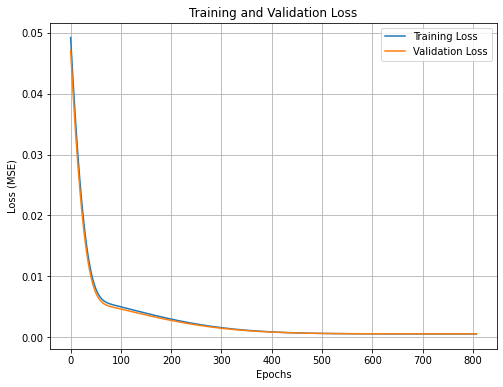

In [34]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

# Make predictionsarr_reduced = arr[0, :]
print("Making predictions on the test set...")
y_pred_normalized = np.abs(model.predict(X_train))

# Denormalize predictions and actual values
#y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized).flatten()
#y_test_denormalized = scaler_y.inverse_transform(y_test).flatten()

# Save the model
model.save('plastic_strain_predictor_model.h5')
print("Model saved as 'plastic_strain_predictor_model.h5'")

# Plot training and validation loss
plot_loss(history, filename='loss_curve.png')

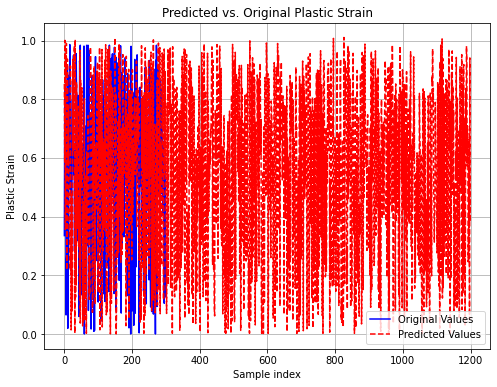

Plot saved as predicted_vs_actual


In [35]:
# Plot predicted vs original plastic strain
plot_predicted_vs_actual(y_test, y_pred_normalized, filename='predicted_vs_actual.png')
#plot_predicted_vs_actual(y_test, y_pred_de, filename='predicted_vs_actual.png')

In [36]:
# Function to calculate stress from predicted plastic strain values using return mapping
def calculate_stress_from_plastic_strain(plastic_strain_values, strain_values, material_constants):
    # Unpack material constants
    E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q = material_constants
    
    # Initialize variables for kinematic and isotropic hardening
    sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0
    
    stress_values = []
    
    # Loop through each strain and corresponding predicted plastic strain
    for i in range(len(plastic_strain_values)):
        eps_p_nn = plastic_strain_values[i]  # Predicted plastic strain from the neural network
        eps = strain_values[i]               # Total strain (input strain)
        
        # Elastic predictor step
        sigma_trial, yield_function = elastic_predictor(eps, eps_p_nn, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        if yield_function <= 0:
            sigma_updated=sigma_trial
        else:      
            # Return mapping algorithm to calculate final stress
            sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            eps, eps_p_nn, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
            c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y)

        # Append the updated stress value to the list
        stress_values.append(sigma_updated)
    
    return np.array(stress_values)


In [37]:

# Get strain values from the test set (or use the
# Define material constants (same as those used for training)
material_constants = [E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q]

# Get strain values from the test set (or use the strain values corresponding to the predicted plastic strain)
strain_values_test = training[:, 11]  # Assuming the last column of X_test is the strain values

y_pred_normalized_nn = model.predict(X_normalized)
#y_pred_normalized_nn = training[:,-1]
y_pred_normalized_nn = np.squeeze(y_pred_normalized_nn)


#stress_values_predicted = calculate_stress_from_plastic_strain(y_pred_normalized_nn, strain_values_test, material_constants)
stress_values_predicted =193000*(strain_values_test - y_pred_normalized_nn)

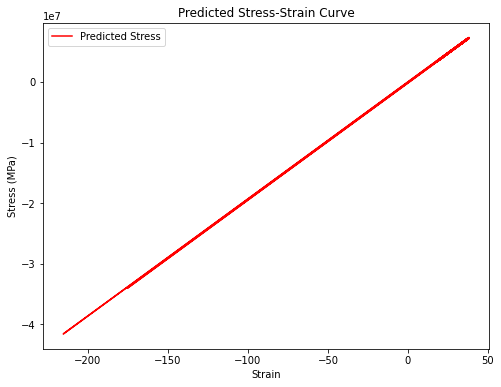

In [38]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
#plt.plot(strain_values_test, training[:,-2], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

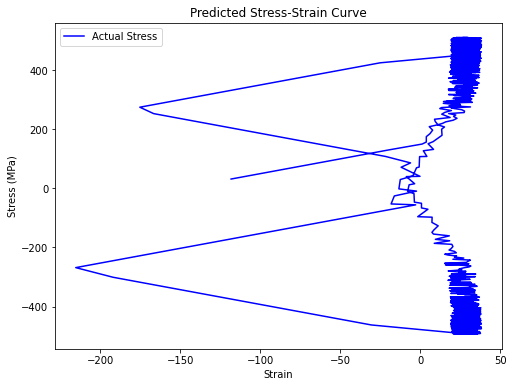

In [39]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot(strain_values_test, training[:,-2], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()